In [2]:
import numpy as np
import pandas as pd
import os
from glob import glob 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pickle
import torch
import sklearn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments, RobertaConfig, RobertaTokenizer, RobertaForSequenceClassification, BertTokenizer
#from load_data import *

In [3]:
train = pd.read_csv("../dataset/train/train.csv")

In [4]:
MODEL_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(tokenizer)

def preprocessing_dataset(dataset):
    subject_entity = []
    object_entity = []
    for i,j in zip(dataset['subject_entity'], dataset['object_entity']):
        # i = i[i.find('word')+8: i.find('start_idx')-4]
        # j = j[j.find('word')+8: j.find('start_idx')-4]
        
        # 기존 코드
        i = i[1:-1].split(',')[0].split(':')[1]
        j = j[1:-1].split(',')[0].split(':')[1]

        subject_entity.append(i)
        object_entity.append(j)
    out_dataset = pd.DataFrame({'id':dataset['id'], 'sentence':dataset['sentence'],'subject_entity':subject_entity,'object_entity':object_entity,'label':dataset['label'],})
    return out_dataset

def load_data(dataset_dir):
    pd_dataset = pd.read_csv(dataset_dir)
    dataset = preprocessing_dataset(pd_dataset)
    return dataset



PreTrainedTokenizerFast(name_or_path='klue/bert-base', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [5]:
train_dataset = load_data("../dataset/train/train.csv")

In [6]:
def tokenized_dataset(dataset, tokenizer):
    concat_entity = []
    for e01, e02 in zip(dataset['subject_entity'], dataset['object_entity']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
      concat_entity,
      list(dataset['sentence']),
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=256,
      add_special_tokens=True,
      )
    return tokenized_sentences

tokenized_train = tokenized_dataset(train_dataset, tokenizer)

## Tokenized 된 sentence 의 길이 파악해보기 
-> max_length 파악하기 위함
-> 시각화를 다르게 표현하지 못하고 사용
-> max_length = 256 사용하기 좋을 듯하다

In [19]:
token_length = []
for i in tokenized_train.attention_mask :
    token_length.append(int(sum(i)))
len(token_length)

32470

In [26]:
token_length[25000]

65

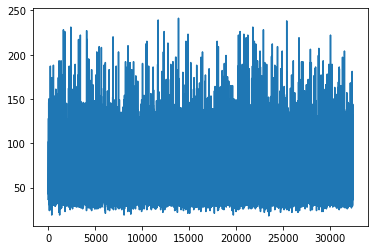

In [14]:
plt.plot(token_length)

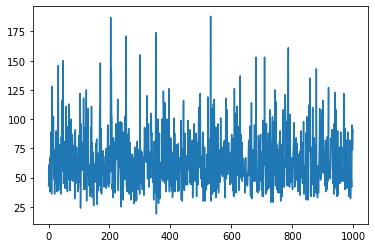

In [28]:
plt.plot(token_length[0:1000])

## Data Generation
[KoEDA 링크](https://github.com/toriving/KoEDA)

In [31]:
# !pip install koeda

In [33]:
from koeda import EDA

In [39]:
eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.3, alpha_rs=0.3, prob_rd=0.3
)

In [41]:
text = "균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪고 있는 대구광역시에 행복박스를 전달했다고 10일 밝혔다."
result = eda(text)
print(result)

균일가 생활용품점 (주)아성다이소(대표 박정상)는 코로나19 바이러스로 어려움을 겪고 있는 대구광역시에 행복박스를 전달했다고 10일 밝혔다.


In [42]:
text = "중공군에게 온전히 대항할 수 없을 정도로 약해진 국민당은 타이베이로 수도를 옮기는 것을 결정해, 남아있는 중화민국군의 병력이나 국가, 개인의 재산등을 속속 타이완으로 옮기기 시작해, 12월에는 중앙 정부 기구도 모두 이전해 타이베이 시를 중화민국의 새로운 수도로 삼았다."
result = eda(text)
print(result)

중공군에게 온전히 대항 없을 정도 국민당은 타이베이로 수도 결정해, 남아있는 의 병력이나 국가, 의 재산등을 속속 타이완으로 옮기기 해, 중앙 기구 모두 이전해 타이베이 시를 중화민국의 새로운 로 삼았다.


In [1]:
from koeda import EasyDataAugmentation
from koeda import AEDA
from koeda import EDA

In [ ]:
eda = EDA(
    morpheme_analyzer="Okt", alpha_sr=0.3, alpha_ri=0.3, alpha_rs=0.3, prob_rd=0.3
)

In [8]:
augmenter = EDA(
              morpheme_analyzer = "Okt",  # Default = "Okt"
              alpha_sr = 0.1,
              alpha_ri = 0.1,
              alpha_rs = 0.1,
              prob_rd = 0.1
            )

In [11]:
for i in range(10) :
    print(augmenter(train['sentence'][0]))
# 〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다

〈Something〉는 조지 해리슨송곳니 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.
〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다 득 .
〈Road〉는에조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Something》 담은 노래다.
〈Something〉는 조지 해리슨이 쓰고 가 1969년 앨범 《Abbey Road》에 담은 노래다.
〈〉는 조지 이 쓰고 비틀즈가 1969년 앨범 《 Road》에 담은 노래다.
〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 얻 《Abbey Road》에 담은 노래다.
〈Something〉는 조지 해리슨잡 쓰고 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래다.
〈Something〉는 조지 해리슨이 쓰고 가 1969년 앨범 《Abbey Road》에 담은 노래다.
〈Something〉는 》 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey Road조지에다담은 노래 .
〈Something〉 조지 해리슨이 비틀즈가 1969년 앨범 《Abbey Road》에 담은 노래.


In [12]:
test = pd.DataFrame()

In [36]:
a = {'id' : 32470, 'sentence' : "Test", "subject_entity" : "a", "object_entity" : "b", "label" : "bc", "source" : "wik"}
b = train.append(a, ignore_index = True)

In [42]:
b[-1:]

,id,sentence,subject_entity,object_entity,label,source
32470,32470,Test,a,b,bc,wik


In [43]:
id_num = len(train)

32470

## Object 를 구분할 수 있는 speical token 주고 모델 돌려보기

In [7]:
def tokenized_dataset(dataset, tokenizer):
    concat_entity = []
    for e01, e02 in zip(dataset['subject_entity'], dataset['object_entity']):
        temp = ''
        temp = e01 + '[SEP]' + e02
        concat_entity.append(temp)
    tokenized_sentences = tokenizer(
      concat_entity,
      list(dataset['sentence']),
      return_tensors="pt",
      padding=True,
      truncation=True,
      max_length=256,
      add_special_tokens=True,
      )
    return tokenized_sentences

tokenized_train = tokenized_dataset(train_dataset, tokenizer)

In [16]:
print(tokenized_train[0].tokens)

['[CLS]', "'", '비틀즈', "'", '[SEP]', "'", '조지', '해리', '##슨', "'", '[SEP]', '〈', 'So', '##me', '##th', '##ing', '〉', '는', '조지', '해리', '##슨', '##이', '쓰', '##고', '비틀즈', '##가', '1969', '##년', '앨범', '《', 'Ab', '##be', '##y', 'Ro', '##ad', '》', '에', '담', '##은', '노래', '##다', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

- [CLS] Subject, [SEP], Object, [SEP], sentence 형태로 되어 잉씀
- 이것에서 sentence 에서도 subject와 object 를 구분해줄 수 있는 special tokens 를 넣어보자

In [33]:
train_dataset[0:1]

,id,sentence,subject_entity,object_entity,label
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,'비틀즈','조지 해리슨',no_relation


In [46]:
train_dataset[]

id
sentence
subject_entity
object_entity
label


In [51]:
(str(train_dataset[0:1]['sentence']).find('비틀즈'))

29

In [60]:
str(train_dataset[0:1]['sentence'])[:28] + " [test] " + str(train_dataset[0:1]['sentence'])[29:]

'0    〈Something〉는 조지 해리슨이 쓰고 [test] 비틀즈가 1969년 앨범 《Abbey R...\nName: sentence, dtype: object'